In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func, compartment_restrainer
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import time
import os
import seaborn as sns

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Using TensorFlow backend.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
# Make up some populations (take as known)
M = 3
np.random.seed(0)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)
population_fraction = population/np.sum(population)
print (np.sum(population))

[4241. 3868. 1023.] [144101. 110004. 124468.]
378573.0


## Reference trajectory

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 7, 3)
tmat.add_transition('A', 'I', 5, 3)
tmat.add_transition('I', 'R', 14, 4)
start = np.zeros((M, C))

In [4]:
infect_fxn = maxentep.contact_infection_func(infections_compartments)
timesteps = 250
model = maxentep.MetaModel(infect_fxn, timesteps, populations=population_fraction)

In [5]:
# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# start[0,0] = 0.1
# start[0,3] = 0.01
# start[0,1] = 0.2
start[0,2] = 0.02
start[0,1] = 0.05
np.random.seed(0)
# R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = np.array([[1000, 400, 10],
             [0, 300, 300],
             [300, 300, 1000]])
R_norm = R / np.sum(R, axis=1)
print (R_norm)
print(tmat.value)

[[0.70921986 0.66666667 0.00625   ]
 [0.         0.5        0.1875    ]
 [0.21276596 0.5        0.625     ]]
[[0.85714286 0.14285714 0.         0.        ]
 [0.         0.8        0.2        0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


In [6]:
ref_traj = model(R_norm, tmat.value, start, 0.025)[0]
print (ref_traj.shape)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(250, 3, 5)


In [7]:
# def f(beta, ntot, ninf):
#     p = 1 - tf.math.exp(tf.math.log(1 - tf.reshape(beta, (-1, 1)))
#                           * tf.reduce_sum((ninf) / ntot[:, :, tf.newaxis], axis=2))
#     return p
# p = []
# for i in np.linspace(0,1,10):
#     ninf = np.zeros((1,M), dtype = np.float32)
#     ninf[0,0] = i
#     print (f(0.01, np.ones((1,M), dtype = np.float32),ninf))
#     p.append(f(0.01, np.ones((1,M), dtype = np.float32),ninf))


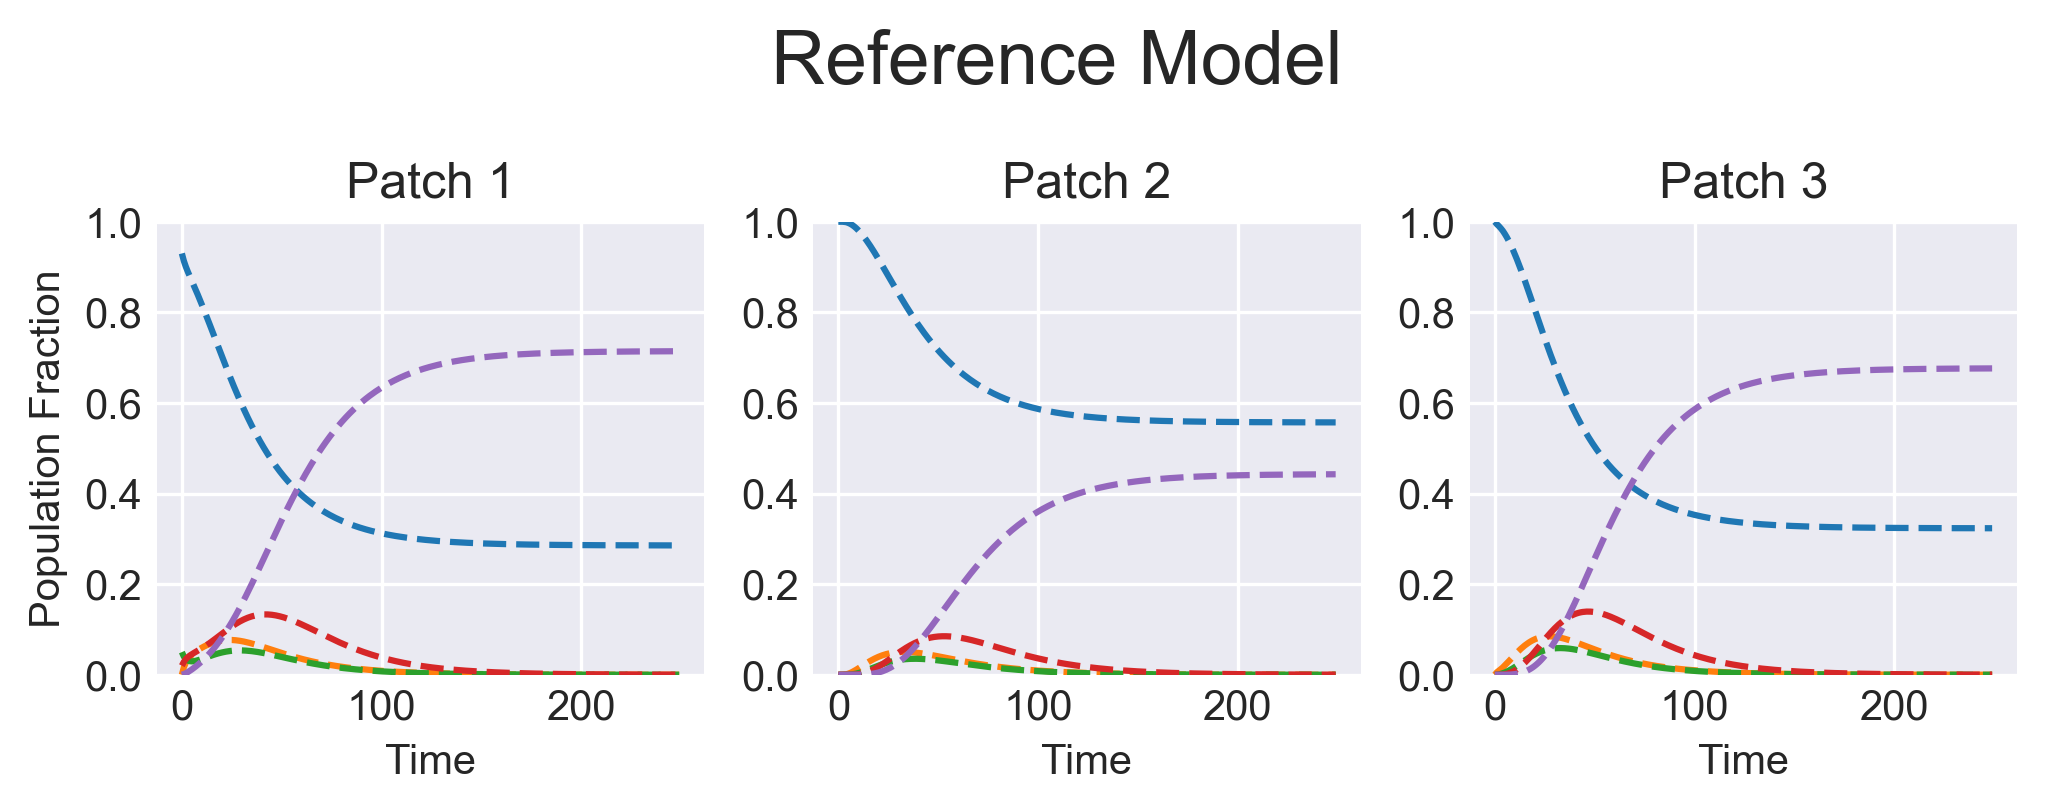

tf.Tensor(
[[9.3000001e-01 0.0000000e+00 5.0000001e-02 2.0000000e-02 0.0000000e+00]
 [9.1351068e-01 1.6489347e-02 4.0000003e-02 2.8571427e-02 1.4285714e-03]
 [9.0063554e-01 2.7008828e-02 3.4355622e-02 3.4530610e-02 3.4693875e-03]
 ...
 [2.8569031e-01 9.8567813e-05 8.5043037e-05 4.6003459e-04 7.1366608e-01]
 [2.8567964e-01 9.5171024e-05 8.2115548e-05 4.4418356e-04 7.1369892e-01]
 [2.8566933e-01 9.1897942e-05 7.9288300e-05 4.2887928e-04 7.1373063e-01]], shape=(230, 5), dtype=float32)
tf.Tensor(
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 ...
 [5.57283759e-01 1.12182679e-04 9.67724918e-05 5.21353155e-04
  4.41985935e-01]
 [5.57271600e-01 1.08315973e-04 9.34440905e-05 5.03468153e-04
  4.42023188e-01]
 [5.57259798e-01 1.04594495e-04 9.02289903e-05 4.86194942e-04
  4.42059159e-01]], shape=(230, 5),

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Reference Model', y = 1.2, fontsize = 18)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()
print (ref_traj[:-20:,0,:])
print (ref_traj[:-20:,1,:])
print (ref_traj[:-20:,1,:] == ref_traj[:-20:,0,:])
# print (tf.reduce_sum(ref_traj[:,0,:],axis=-1))

## Sample SEAIR Trajectories

Creating a set of trajectories.

In [9]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 7, 3)
tmat.add_transition('A', 'I', 5, 2)
tmat.add_transition('I', 'R', 14, 4)
full_compartments = ['S'] + compartments

In [10]:
# starting fractions probabilities
start_logits = np.zeros((M)) #anywhere
start_logits[0]=np.log(0.9)
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_var = 0.9
hyper_pram.beta_start = 0.1
hyper_pram.beta_high = 0.5
hyper_pram.beta_low = 0.01
hyper_pram.start_mean = 0.001
hyper_pram.start_high = 0.001
# hyper_pram.R_var = 0.1
# hyper_pram.start_high = 0.01

In [11]:
param_model = maxentep.MetaParameterJoint(start_logits, R_norm, tmat, name='unbiased model', hypers = hyper_pram)

In [12]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 1024
batches = 4
batch_size = N*batches
outs = []
timesteps = 250
# infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
model = maxentep.MetaModel(infect_fxn, timesteps, populations=population_fraction)
for b in tqdm.tqdm(range(batches)):
    psample = param_model.sample(N)
    outs.append(model(*psample))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.95s/it]

(4096, 250, 3, 5)


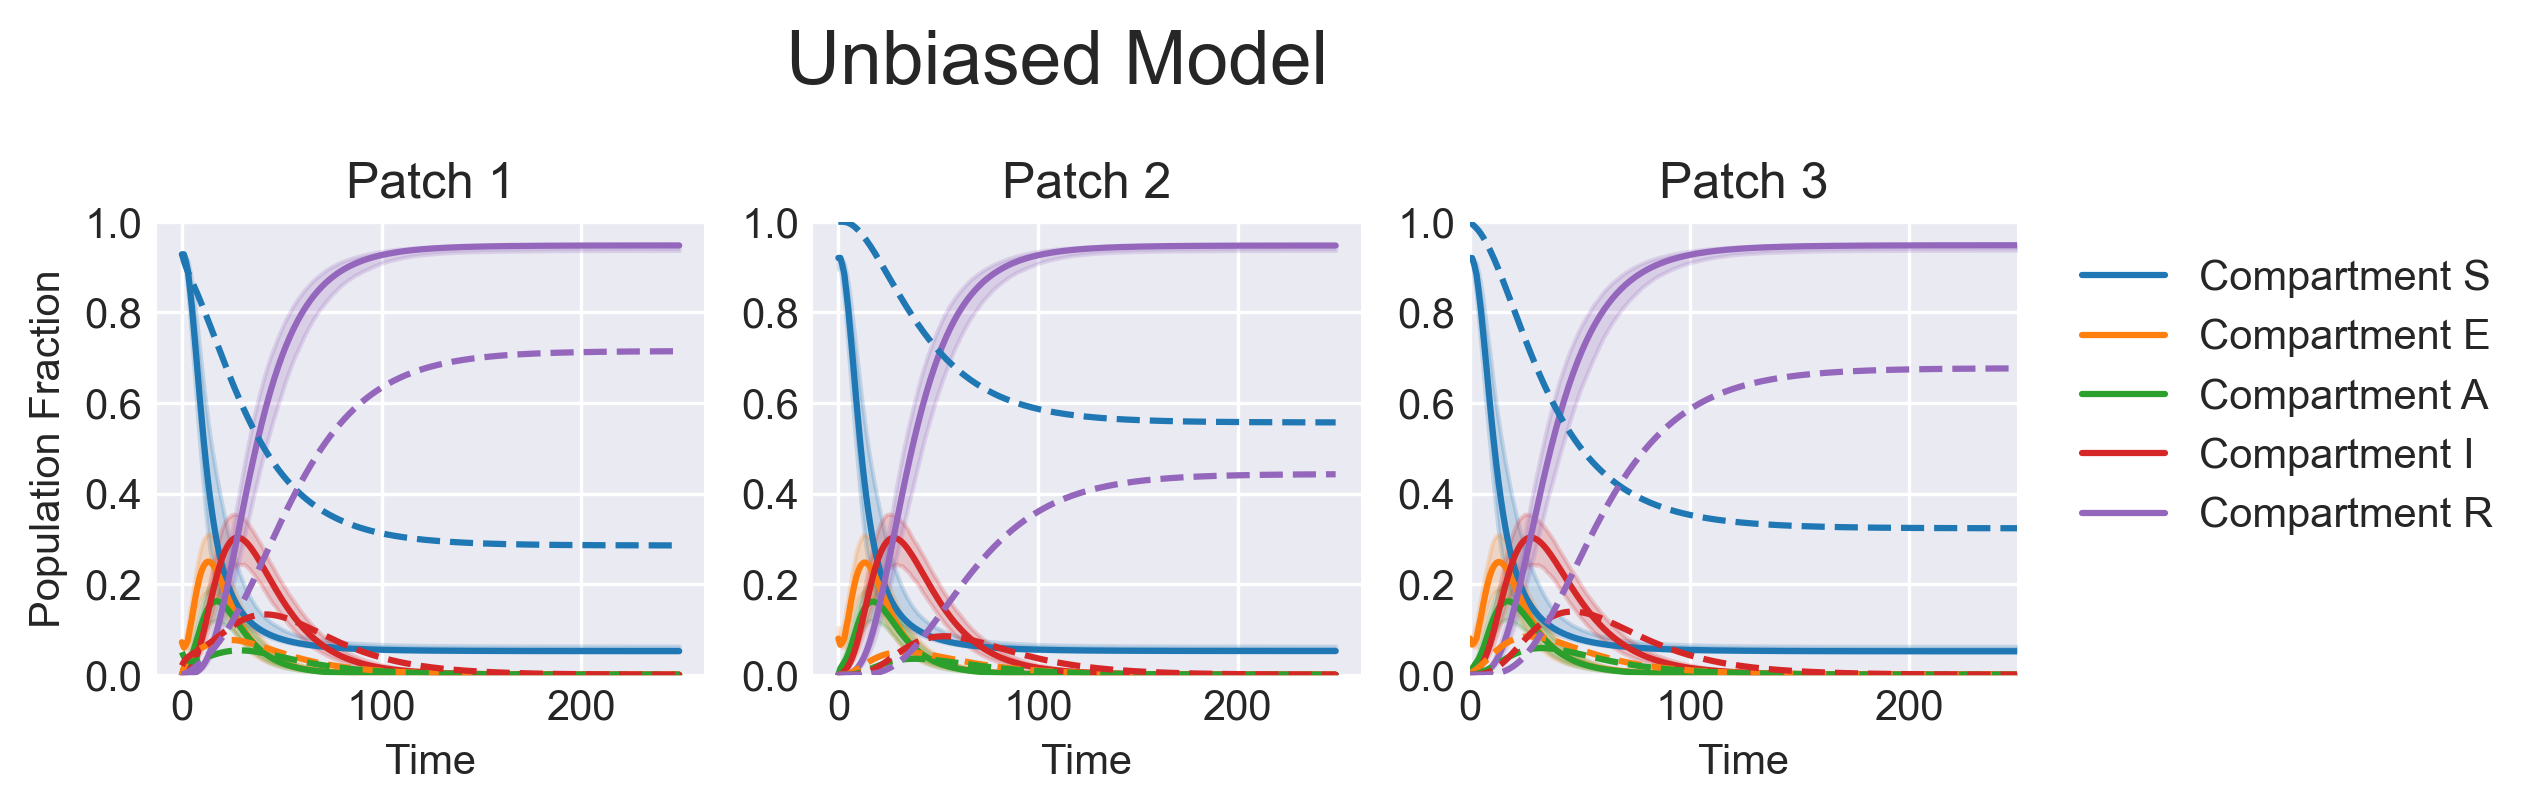

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Unbiased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_0, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_1, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_2, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()

## Make restraints from reference trajectory

In [15]:
npoints = 10
# prior = maxentep.EmptyPrior()
prior = maxentep.Laplace(0.1)
restrained_compartments = [0, 3, 4] #(infected patch)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
number_of_restrained_compartments = len(restrained_compartments) 
# restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
restrained_patches = np.array([0])
print ('Patches restrained:', restrained_patches)
print ('Total number of restraints: ', npoints*number_of_restrained_compartments*len(restrained_patches))
print ('Compartments restrained: ', restrained_compartments_names)
restraints, plot_fxns_list = maxentep.compartment_restrainer(restrained_patches, restrained_compartments, npoints, ref_traj, prior, noise=0, start_time= 0, end_time = 100)

Patches restrained: [0]
Total number of restraints:  30
Compartments restrained:  ['S', 'I', 'R']
Restraints are set on this time range: [0, 100]
59 0.40076563 0.40076562762260437
45 0.47408512 0.47408512234687805
31 0.58688277 0.5868827700614929
80 0.34004194 0.3400419354438782
17 0.7380277 0.7380276918411255
94 0.31863117 0.3186311721801758
66 0.37535176 0.37535175681114197
10 0.8168713 0.8168712854385376
52 0.43315676 0.4331567585468292
73 0.35550547 0.35550546646118164
59 0.11300838 0.11300837993621826
80 0.06942841 0.06942840665578842
38 0.13152371 0.1315237134695053
45 0.13207568 0.13207568228244781
24 0.10324775 0.1032477468252182
31 0.121692084 0.12169208377599716
17 0.08018887 0.08018887042999268
94 0.045822185 0.04582218453288078
87 0.056746352 0.05674635246396065
73 0.083592534 0.08359253406524658
31 0.16494873 0.1649487316608429
10 0.030205293 0.030205292627215385
38 0.22828968 0.2282896786928177
3 0.0066124243 0.006612424273043871
59 0.41940045 0.4194004535675049
17 0.0639

## Visualizing Restraints

Text(0, 0.5, 'Population Fraction')

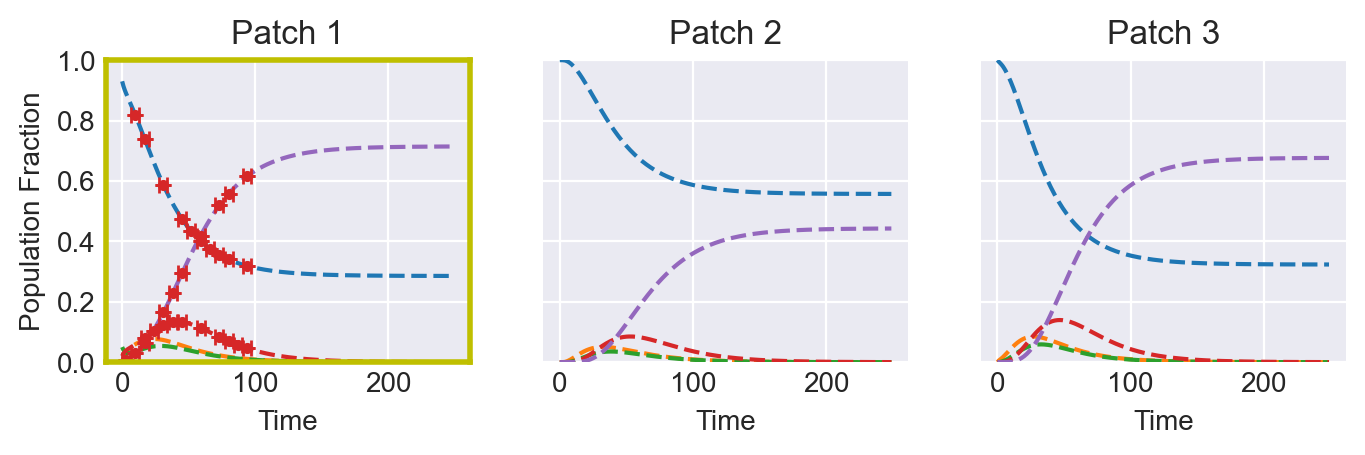

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=M, sharex=True,
                           sharey=True, figsize=(8,2), dpi =200)
for i in range(M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1),ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')


In [17]:
me_model = maxentep.MaxentModel(restraints, ref_traj=ref_traj[np.newaxis,:,:,:], trajs=trajs, population_fraction=population_fraction)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
print (ref_traj[np.newaxis,:,:,:].shape)
print (population_fraction.shape)
print (trajs.shape)

(1, 250, 3, 5)
(3,)
(4096, 250, 3, 5)


In [18]:
me_history = me_model.fit(trajs, batch_size=batch_size,epochs=1000)

Epoch 1/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0990 - ref-error-metric: 4.8397 - ref-error: 4.8397 - weight-entropy: 8.1514
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0983 - ref-error-metric: 4.8569 - ref-error: 4.8569 - weight-entropy: 8.1589
Epoch 3/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0975 - ref-error-metric: 4.8699 - ref-error: 4.8699 - weight-entropy: 8.1665
Epoch 4/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0967 - ref-error-metric: 4.8371 - ref-error: 4.8371 - weight-entropy: 8.1740
Epoch 5/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0959 - ref-error-metric: 4.8519 - ref-error: 4.8519 - weight-entropy: 8.1815
Epoch 6/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0950 - ref-error-metric: 4.8678 - ref-error: 4.8678 - weight-entropy: 8.1890
Epoch 7/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0941 - ref-error-met

1/1 [==============================] - 0s 3ms/step - loss: 5.0514e-04 - ref-error-metric: 4.7857 - ref-error: 4.7857 - weight-entropy: 7.0746
Epoch 55/1000
1/1 [==============================] - 0s 3ms/step - loss: 6.2350e-04 - ref-error-metric: 5.0318 - ref-error: 5.0318 - weight-entropy: 7.0227
Epoch 56/1000
1/1 [==============================] - 0s 3ms/step - loss: 7.9223e-04 - ref-error-metric: 4.8316 - ref-error: 4.8316 - weight-entropy: 6.9766
Epoch 57/1000
1/1 [==============================] - 0s 4ms/step - loss: 9.8619e-04 - ref-error-metric: 4.5937 - ref-error: 4.5937 - weight-entropy: 6.9363
Epoch 58/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - ref-error-metric: 4.7664 - ref-error: 4.7664 - weight-entropy: 6.9017
Epoch 59/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0014 - ref-error-metric: 4.6260 - ref-error: 4.6260 - weight-entropy: 6.8727
Epoch 60/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-

1/1 [==============================] - 0s 3ms/step - loss: 4.5936e-04 - ref-error-metric: 4.7865 - ref-error: 4.7865 - weight-entropy: 7.1499
Epoch 108/1000
1/1 [==============================] - 0s 4ms/step - loss: 4.5534e-04 - ref-error-metric: 4.8110 - ref-error: 4.8110 - weight-entropy: 7.1452
Epoch 109/1000
1/1 [==============================] - 0s 4ms/step - loss: 4.5210e-04 - ref-error-metric: 4.8288 - ref-error: 4.8288 - weight-entropy: 7.1406
Epoch 110/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.4962e-04 - ref-error-metric: 5.1681 - ref-error: 5.1681 - weight-entropy: 7.1361
Epoch 111/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.4785e-04 - ref-error-metric: 4.9446 - ref-error: 4.9446 - weight-entropy: 7.1318
Epoch 112/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.4670e-04 - ref-error-metric: 4.7664 - ref-error: 4.7664 - weight-entropy: 7.1278
Epoch 113/1000
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 4ms/step - loss: 4.4042e-04 - ref-error-metric: 4.9692 - ref-error: 4.9692 - weight-entropy: 7.1227
Epoch 160/1000
1/1 [==============================] - 0s 4ms/step - loss: 4.4028e-04 - ref-error-metric: 4.9776 - ref-error: 4.9776 - weight-entropy: 7.1223
Epoch 161/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.4014e-04 - ref-error-metric: 4.6657 - ref-error: 4.6657 - weight-entropy: 7.1220
Epoch 162/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.4000e-04 - ref-error-metric: 4.8831 - ref-error: 4.8831 - weight-entropy: 7.1216
Epoch 163/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.3987e-04 - ref-error-metric: 4.5810 - ref-error: 4.5810 - weight-entropy: 7.1213
Epoch 164/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.3974e-04 - ref-error-metric: 4.7931 - ref-error: 4.7931 - weight-entropy: 7.1210
Epoch 165/1000
1/1 [==============================] - 0s 4ms/step - loss:

1/1 [==============================] - 0s 3ms/step - loss: 4.3358e-04 - ref-error-metric: 4.8769 - ref-error: 4.8769 - weight-entropy: 7.1200
Epoch 212/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.3344e-04 - ref-error-metric: 5.0283 - ref-error: 5.0283 - weight-entropy: 7.1199
Epoch 213/1000
1/1 [==============================] - 0s 4ms/step - loss: 4.3331e-04 - ref-error-metric: 4.8924 - ref-error: 4.8924 - weight-entropy: 7.1199
Epoch 214/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.3317e-04 - ref-error-metric: 4.9115 - ref-error: 4.9115 - weight-entropy: 7.1198
Epoch 215/1000
1/1 [==============================] - 0s 4ms/step - loss: 4.3304e-04 - ref-error-metric: 4.8293 - ref-error: 4.8293 - weight-entropy: 7.1198
Epoch 216/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.3290e-04 - ref-error-metric: 4.8484 - ref-error: 4.8484 - weight-entropy: 7.1198
Epoch 217/1000
1/1 [==============================] - 0s 9ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 4.2650e-04 - ref-error-metric: 4.9091 - ref-error: 4.9091 - weight-entropy: 7.1189
Epoch 264/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.2636e-04 - ref-error-metric: 4.6974 - ref-error: 4.6974 - weight-entropy: 7.1188
Epoch 265/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.2622e-04 - ref-error-metric: 4.7674 - ref-error: 4.7674 - weight-entropy: 7.1188
Epoch 266/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.2608e-04 - ref-error-metric: 4.5005 - ref-error: 4.5005 - weight-entropy: 7.1188
Epoch 267/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.2595e-04 - ref-error-metric: 4.8289 - ref-error: 4.8289 - weight-entropy: 7.1188
Epoch 268/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.2581e-04 - ref-error-metric: 4.8577 - ref-error: 4.8577 - weight-entropy: 7.1188
Epoch 269/1000
1/1 [==============================] - 0s 3ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 4.1933e-04 - ref-error-metric: 4.5512 - ref-error: 4.5512 - weight-entropy: 7.1177
Epoch 316/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.1919e-04 - ref-error-metric: 4.7360 - ref-error: 4.7360 - weight-entropy: 7.1177
Epoch 317/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.1906e-04 - ref-error-metric: 4.9636 - ref-error: 4.9636 - weight-entropy: 7.1177
Epoch 318/1000
1/1 [==============================] - 0s 4ms/step - loss: 4.1892e-04 - ref-error-metric: 4.9135 - ref-error: 4.9135 - weight-entropy: 7.1176
Epoch 319/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.1878e-04 - ref-error-metric: 4.9723 - ref-error: 4.9723 - weight-entropy: 7.1176
Epoch 320/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.1864e-04 - ref-error-metric: 5.1502 - ref-error: 5.1502 - weight-entropy: 7.1176
Epoch 321/1000
1/1 [==============================] - 0s 3ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 4.1220e-04 - ref-error-metric: 5.0612 - ref-error: 5.0612 - weight-entropy: 7.1165
Epoch 368/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.1206e-04 - ref-error-metric: 5.0363 - ref-error: 5.0363 - weight-entropy: 7.1165
Epoch 369/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.1192e-04 - ref-error-metric: 4.8585 - ref-error: 4.8585 - weight-entropy: 7.1165
Epoch 370/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.1179e-04 - ref-error-metric: 4.7606 - ref-error: 4.7606 - weight-entropy: 7.1165
Epoch 371/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.1165e-04 - ref-error-metric: 4.9664 - ref-error: 4.9664 - weight-entropy: 7.1164
Epoch 372/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.1152e-04 - ref-error-metric: 4.7500 - ref-error: 4.7500 - weight-entropy: 7.1164
Epoch 373/1000
1/1 [==============================] - 0s 4ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 4.0515e-04 - ref-error-metric: 4.9330 - ref-error: 4.9330 - weight-entropy: 7.1154
Epoch 420/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.0502e-04 - ref-error-metric: 4.8784 - ref-error: 4.8784 - weight-entropy: 7.1153
Epoch 421/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.0489e-04 - ref-error-metric: 4.8717 - ref-error: 4.8717 - weight-entropy: 7.1153
Epoch 422/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.0475e-04 - ref-error-metric: 4.9078 - ref-error: 4.9078 - weight-entropy: 7.1153
Epoch 423/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.0462e-04 - ref-error-metric: 4.7941 - ref-error: 4.7941 - weight-entropy: 7.1153
Epoch 424/1000
1/1 [==============================] - 0s 4ms/step - loss: 4.0448e-04 - ref-error-metric: 4.7284 - ref-error: 4.7284 - weight-entropy: 7.1152
Epoch 425/1000
1/1 [==============================] - 0s 3ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 3.9822e-04 - ref-error-metric: 5.1465 - ref-error: 5.1465 - weight-entropy: 7.1142
Epoch 472/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.9809e-04 - ref-error-metric: 4.9919 - ref-error: 4.9919 - weight-entropy: 7.1142
Epoch 473/1000
1/1 [==============================] - 0s 4ms/step - loss: 3.9796e-04 - ref-error-metric: 5.0190 - ref-error: 5.0190 - weight-entropy: 7.1142
Epoch 474/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.9782e-04 - ref-error-metric: 4.7847 - ref-error: 4.7847 - weight-entropy: 7.1142
Epoch 475/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.9769e-04 - ref-error-metric: 4.7694 - ref-error: 4.7694 - weight-entropy: 7.1142
Epoch 476/1000
1/1 [==============================] - 0s 4ms/step - loss: 3.9756e-04 - ref-error-metric: 4.9958 - ref-error: 4.9958 - weight-entropy: 7.1141
Epoch 477/1000
1/1 [==============================] - 0s 3ms/step - loss:

1/1 [==============================] - 0s 5ms/step - loss: 3.9139e-04 - ref-error-metric: 4.7479 - ref-error: 4.7479 - weight-entropy: 7.1132
Epoch 524/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.9126e-04 - ref-error-metric: 4.9727 - ref-error: 4.9727 - weight-entropy: 7.1132
Epoch 525/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.9113e-04 - ref-error-metric: 4.8103 - ref-error: 4.8103 - weight-entropy: 7.1131
Epoch 526/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.9100e-04 - ref-error-metric: 4.9534 - ref-error: 4.9534 - weight-entropy: 7.1131
Epoch 527/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.9087e-04 - ref-error-metric: 4.7611 - ref-error: 4.7611 - weight-entropy: 7.1131
Epoch 528/1000
1/1 [==============================] - 0s 4ms/step - loss: 3.9074e-04 - ref-error-metric: 4.9396 - ref-error: 4.9396 - weight-entropy: 7.1131
Epoch 529/1000
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 3ms/step - loss: 3.8464e-04 - ref-error-metric: 4.8664 - ref-error: 4.8664 - weight-entropy: 7.1122
Epoch 576/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.8451e-04 - ref-error-metric: 4.8557 - ref-error: 4.8557 - weight-entropy: 7.1122
Epoch 577/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.8438e-04 - ref-error-metric: 4.7374 - ref-error: 4.7374 - weight-entropy: 7.1122
Epoch 578/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.8425e-04 - ref-error-metric: 4.9210 - ref-error: 4.9210 - weight-entropy: 7.1122
Epoch 579/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.8412e-04 - ref-error-metric: 4.8738 - ref-error: 4.8738 - weight-entropy: 7.1122
Epoch 580/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.8399e-04 - ref-error-metric: 4.9647 - ref-error: 4.9647 - weight-entropy: 7.1121
Epoch 581/1000
1/1 [==============================] - 0s 3ms/step - loss:

1/1 [==============================] - 0s 5ms/step - loss: 3.7793e-04 - ref-error-metric: 4.8726 - ref-error: 4.8726 - weight-entropy: 7.1114
Epoch 628/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.7781e-04 - ref-error-metric: 4.8993 - ref-error: 4.8993 - weight-entropy: 7.1114
Epoch 629/1000
1/1 [==============================] - 0s 4ms/step - loss: 3.7768e-04 - ref-error-metric: 4.9334 - ref-error: 4.9334 - weight-entropy: 7.1114
Epoch 630/1000
1/1 [==============================] - 0s 4ms/step - loss: 3.7755e-04 - ref-error-metric: 4.8721 - ref-error: 4.8721 - weight-entropy: 7.1113
Epoch 631/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.7742e-04 - ref-error-metric: 4.6954 - ref-error: 4.6954 - weight-entropy: 7.1113
Epoch 632/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.7729e-04 - ref-error-metric: 4.8906 - ref-error: 4.8906 - weight-entropy: 7.1113
Epoch 633/1000
1/1 [==============================] - 0s 5ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 3.7126e-04 - ref-error-metric: 5.0687 - ref-error: 5.0687 - weight-entropy: 7.1107
Epoch 680/1000
1/1 [==============================] - 0s 5ms/step - loss: 3.7113e-04 - ref-error-metric: 5.0229 - ref-error: 5.0229 - weight-entropy: 7.1106
Epoch 681/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.7100e-04 - ref-error-metric: 4.9188 - ref-error: 4.9188 - weight-entropy: 7.1106
Epoch 682/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.7087e-04 - ref-error-metric: 4.8915 - ref-error: 4.8915 - weight-entropy: 7.1106
Epoch 683/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.7074e-04 - ref-error-metric: 4.8253 - ref-error: 4.8253 - weight-entropy: 7.1106
Epoch 684/1000
1/1 [==============================] - 0s 5ms/step - loss: 3.7061e-04 - ref-error-metric: 4.6279 - ref-error: 4.6279 - weight-entropy: 7.1106
Epoch 685/1000
1/1 [==============================] - 0s 3ms/step - loss:

1/1 [==============================] - 0s 3ms/step - loss: 3.6458e-04 - ref-error-metric: 4.8639 - ref-error: 4.8639 - weight-entropy: 7.1100
Epoch 732/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.6445e-04 - ref-error-metric: 5.0666 - ref-error: 5.0666 - weight-entropy: 7.1100
Epoch 733/1000
1/1 [==============================] - 0s 6ms/step - loss: 3.6432e-04 - ref-error-metric: 4.8892 - ref-error: 4.8892 - weight-entropy: 7.1100
Epoch 734/1000
1/1 [==============================] - 0s 4ms/step - loss: 3.6419e-04 - ref-error-metric: 5.1240 - ref-error: 5.1240 - weight-entropy: 7.1100
Epoch 735/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.6407e-04 - ref-error-metric: 5.0815 - ref-error: 5.0815 - weight-entropy: 7.1100
Epoch 736/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.6394e-04 - ref-error-metric: 4.8935 - ref-error: 4.8935 - weight-entropy: 7.1100
Epoch 737/1000
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 3ms/step - loss: 3.5789e-04 - ref-error-metric: 4.7993 - ref-error: 4.7993 - weight-entropy: 7.1095
Epoch 784/1000
1/1 [==============================] - 0s 5ms/step - loss: 3.5776e-04 - ref-error-metric: 4.9997 - ref-error: 4.9997 - weight-entropy: 7.1095
Epoch 785/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.5763e-04 - ref-error-metric: 4.7334 - ref-error: 4.7334 - weight-entropy: 7.1095
Epoch 786/1000
1/1 [==============================] - 0s 4ms/step - loss: 3.5750e-04 - ref-error-metric: 4.9029 - ref-error: 4.9029 - weight-entropy: 7.1095
Epoch 787/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.5737e-04 - ref-error-metric: 4.9165 - ref-error: 4.9165 - weight-entropy: 7.1095
Epoch 788/1000
1/1 [==============================] - 0s 7ms/step - loss: 3.5724e-04 - ref-error-metric: 5.0021 - ref-error: 5.0021 - weight-entropy: 7.1095
Epoch 789/1000
1/1 [==============================] - 0s 6ms/step - loss:

1/1 [==============================] - 0s 4ms/step - loss: 3.5117e-04 - ref-error-metric: 4.8412 - ref-error: 4.8412 - weight-entropy: 7.1091
Epoch 836/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.5104e-04 - ref-error-metric: 4.5039 - ref-error: 4.5039 - weight-entropy: 7.1091
Epoch 837/1000
1/1 [==============================] - 0s 5ms/step - loss: 3.5091e-04 - ref-error-metric: 4.8687 - ref-error: 4.8687 - weight-entropy: 7.1091
Epoch 838/1000
1/1 [==============================] - 0s 5ms/step - loss: 3.5078e-04 - ref-error-metric: 5.1058 - ref-error: 5.1058 - weight-entropy: 7.1091
Epoch 839/1000
1/1 [==============================] - 0s 4ms/step - loss: 3.5065e-04 - ref-error-metric: 4.9598 - ref-error: 4.9598 - weight-entropy: 7.1091
Epoch 840/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.5052e-04 - ref-error-metric: 5.1145 - ref-error: 5.1145 - weight-entropy: 7.1090
Epoch 841/1000
1/1 [==============================] - 0s 4ms/step - loss:

1/1 [==============================] - 0s 3ms/step - loss: 3.4443e-04 - ref-error-metric: 5.0165 - ref-error: 5.0165 - weight-entropy: 7.1087
Epoch 888/1000
1/1 [==============================] - 0s 5ms/step - loss: 3.4430e-04 - ref-error-metric: 4.7539 - ref-error: 4.7539 - weight-entropy: 7.1087
Epoch 889/1000
1/1 [==============================] - 0s 6ms/step - loss: 3.4417e-04 - ref-error-metric: 4.9683 - ref-error: 4.9683 - weight-entropy: 7.1087
Epoch 890/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.4404e-04 - ref-error-metric: 5.0099 - ref-error: 5.0099 - weight-entropy: 7.1087
Epoch 891/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.4391e-04 - ref-error-metric: 4.8405 - ref-error: 4.8405 - weight-entropy: 7.1087
Epoch 892/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.4378e-04 - ref-error-metric: 4.6844 - ref-error: 4.6844 - weight-entropy: 7.1087
Epoch 893/1000
1/1 [==============================] - 0s 3ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 3.3767e-04 - ref-error-metric: 4.6442 - ref-error: 4.6442 - weight-entropy: 7.1084
Epoch 940/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.3753e-04 - ref-error-metric: 4.9980 - ref-error: 4.9980 - weight-entropy: 7.1084
Epoch 941/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.3740e-04 - ref-error-metric: 5.0700 - ref-error: 5.0700 - weight-entropy: 7.1084
Epoch 942/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.3727e-04 - ref-error-metric: 5.0222 - ref-error: 5.0222 - weight-entropy: 7.1084
Epoch 943/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.3714e-04 - ref-error-metric: 4.7233 - ref-error: 4.7233 - weight-entropy: 7.1084
Epoch 944/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.3701e-04 - ref-error-metric: 4.9352 - ref-error: 4.9352 - weight-entropy: 7.1084
Epoch 945/1000
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 4ms/step - loss: 3.3088e-04 - ref-error-metric: 4.7039 - ref-error: 4.7039 - weight-entropy: 7.1082
Epoch 992/1000
1/1 [==============================] - 0s 4ms/step - loss: 3.3075e-04 - ref-error-metric: 4.7731 - ref-error: 4.7731 - weight-entropy: 7.1082
Epoch 993/1000
1/1 [==============================] - 0s 5ms/step - loss: 3.3062e-04 - ref-error-metric: 4.8469 - ref-error: 4.8469 - weight-entropy: 7.1082
Epoch 994/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.3049e-04 - ref-error-metric: 4.8503 - ref-error: 4.8503 - weight-entropy: 7.1082
Epoch 995/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.3036e-04 - ref-error-metric: 4.9630 - ref-error: 4.9630 - weight-entropy: 7.1082
Epoch 996/1000
1/1 [==============================] - 0s 5ms/step - loss: 3.3023e-04 - ref-error-metric: 4.9349 - ref-error: 4.9349 - weight-entropy: 7.1082
Epoch 997/1000
1/1 [==============================] - 0s 3ms/step - loss:

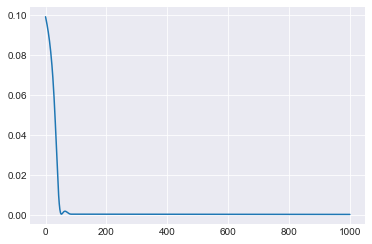

In [19]:
plt.plot(me_history.history['loss'])

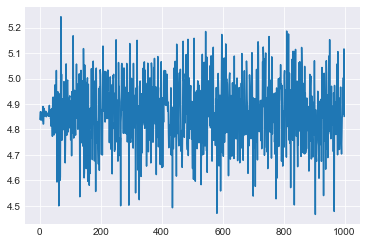

In [20]:
plt.plot(me_history.history['ref-error'])

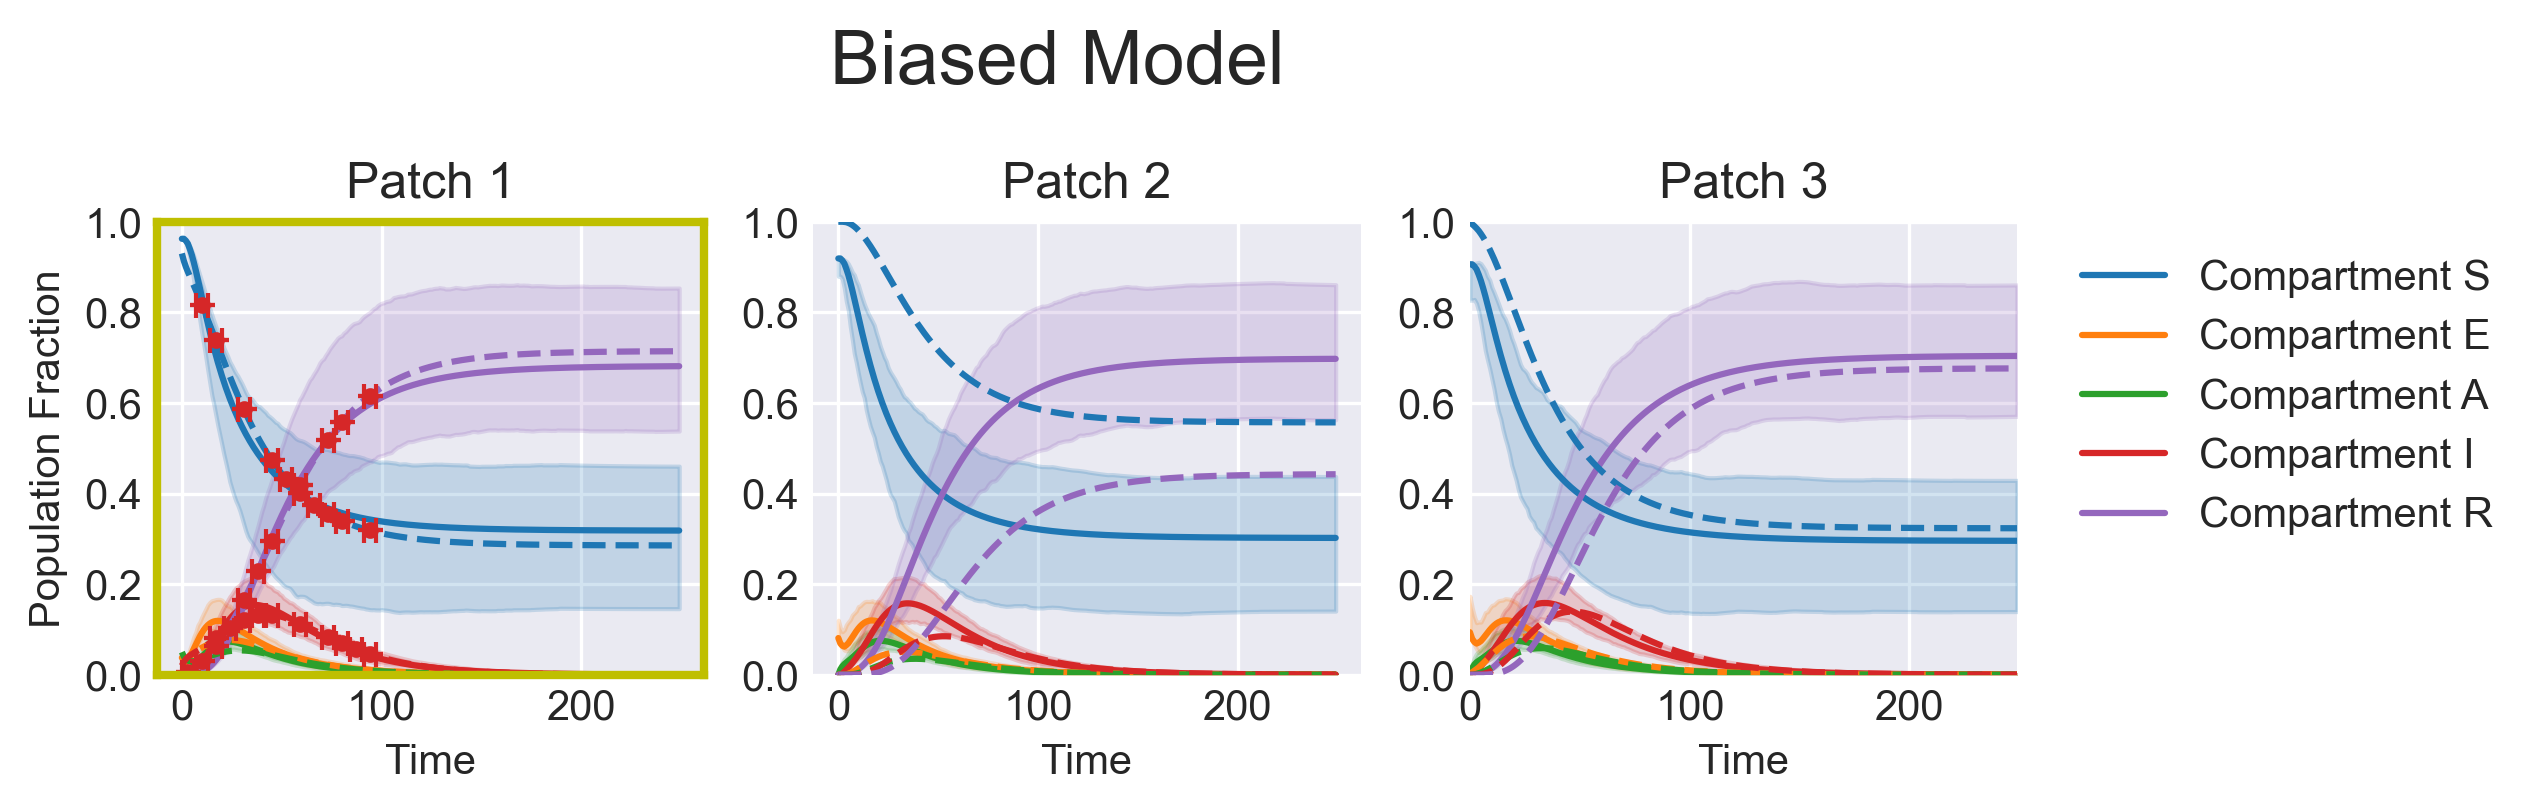

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Biased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,1,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,2,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## Least squares regression

In [22]:
Tmtat = tmat.value
start = np.zeros((M, C))
start[0,0] = 0.05
# start[1,0] = 0.05
beta_start = 0.1
infect = maxentep.ContactInfectionLayer(beta_start, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, R_norm, Tmtat, infect, timesteps, agreement)

In [23]:
rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(timesteps)
regressed_traj = rmodel.get_traj()

250/250 [==============================] - 45s 179ms/step - loss: 0.0356 - output_2_loss: 0.0356


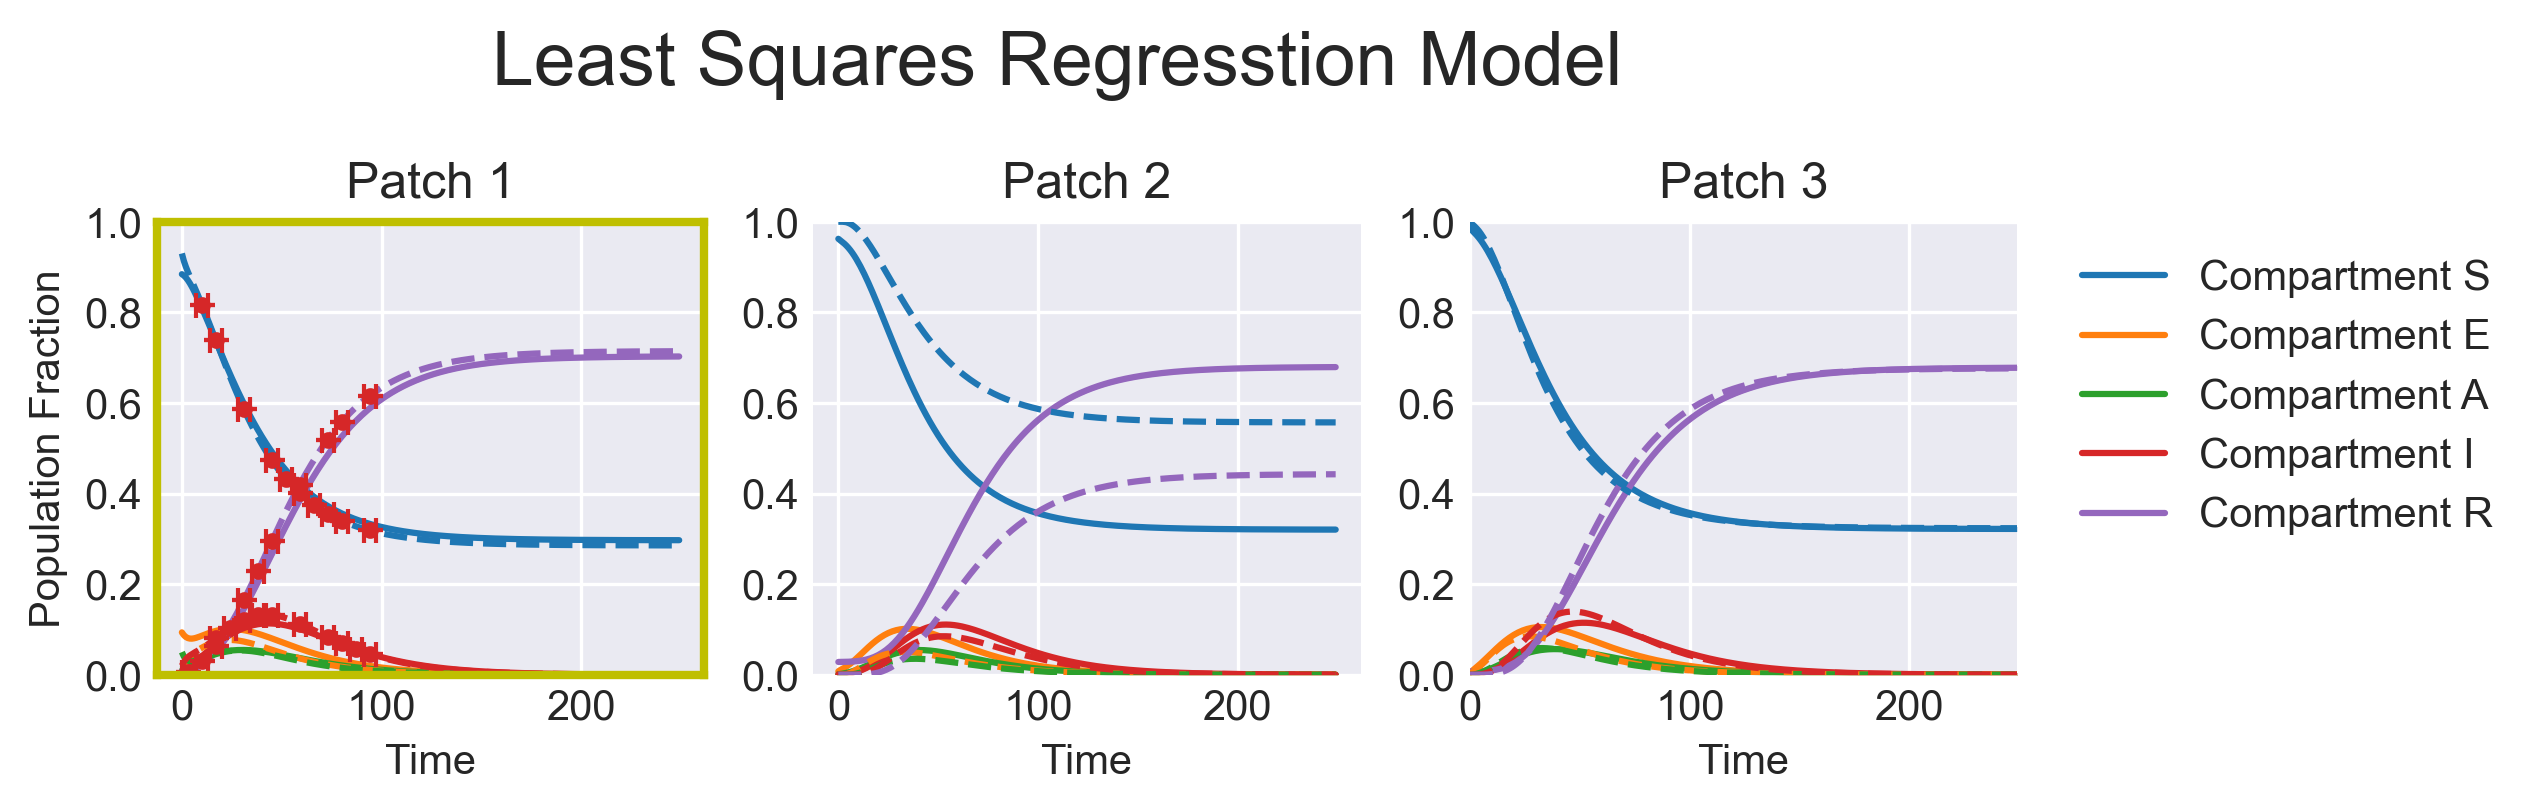

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Least Squares Regresstion Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(regressed_traj[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(regressed_traj[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(regressed_traj[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
#     axs[i].plot(regressed_traj[0,:,i,:])
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## Hyper-biasing

In [25]:
fit_param_model = maxentep.MetaParameterJoint(np.zeros((M,)), R_norm , tmat, name='unbiased_model', hypers = hyper_pram)
fit_param_model.compile(tf.optimizers.SGD(1))
# fit_param_model.compile(tf.optimizers.Adam(0.1))

hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model, reweight=False)
hme_model.compile(tf.keras.optimizers.SGD(learning_rate=1), 'mean_squared_error')

In [26]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=1, param_epochs=16, batch_size=64, epochs=1000)

Epoch 1/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0171 - weight-entropy: 3.4813
Epoch 2/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0063 - weight-entropy: 3.1130
Epoch 3/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0064 - weight-entropy: 3.0773
Epoch 4/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0054 - weight-entropy: 3.0997
Epoch 5/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0052 - weight-entropy: 3.0610
Epoch 6/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0063 - weight-entropy: 3.1074
Epoch 7/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0050 - weight-entropy: 3.0659
Epoch 8/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0053 - weight-entropy: 3.0276
Epoch 9/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0043 - weight-entropy: 3.0489
Epoch 10/1000
64/64 [=========================

64/64 [==============================] - 0s 2ms/step - loss: 0.0040 - weight-entropy: 2.8963
Epoch 72/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.8836
Epoch 73/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 2.8446
Epoch 74/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0040 - weight-entropy: 2.8973
Epoch 75/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0045 - weight-entropy: 2.8757
Epoch 76/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0039 - weight-entropy: 2.8701
Epoch 77/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 2.8604
Epoch 78/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0041 - weight-entropy: 2.8864
Epoch 79/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.8672
Epoch 80/1000
64/64 [==============================

64/64 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.8310
Epoch 148/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 2.8311
Epoch 149/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 2.8553
Epoch 150/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.8441
Epoch 151/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.8578
Epoch 152/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 2.8741
Epoch 153/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 2.8355
Epoch 154/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 2.8478
Epoch 155/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 2.8425
Epoch 156/1000
64/64 [=====================

Epoch 223/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0039 - weight-entropy: 2.8681
Epoch 224/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 2.8461
Epoch 225/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.8686
Epoch 226/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.8424
Epoch 227/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 2.8757
Epoch 228/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.8292
Epoch 229/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.8431
Epoch 230/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0042 - weight-entropy: 2.8827
Epoch 231/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.8356
Epoch 232/1000
64/64 [======

64/64 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 2.8632
Epoch 299/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 2.8570
Epoch 300/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 2.8277
Epoch 301/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 2.8494
Epoch 302/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 2.8138
Epoch 303/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.8595
Epoch 304/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.8350
Epoch 305/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.8431
Epoch 306/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.8456
Epoch 307/1000
64/64 [=====================

64/64 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 2.8765
Epoch 374/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.8203
Epoch 375/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.8364
Epoch 376/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.8306
Epoch 377/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.8379
Epoch 378/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 2.8035
Epoch 379/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 2.8421
Epoch 380/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 2.8075
Epoch 381/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 2.8166
Epoch 382/1000
64/64 [=====================

Epoch 449/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 2.8383
Epoch 450/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 2.8461
Epoch 451/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.8257
Epoch 452/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 2.8341
Epoch 453/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.8016
Epoch 454/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 2.8289
Epoch 455/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 2.8087
Epoch 456/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 2.8018
Epoch 457/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.8382
Epoch 458/1000
64/64 [======

64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.8146
Epoch 525/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.8073
Epoch 526/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.8289
Epoch 527/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 2.7975
Epoch 528/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 2.8369
Epoch 529/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.8115
Epoch 530/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.7923
Epoch 531/1000
64/64 [==============================] - ETA: 0s - loss: 0.0025 - weight-entropy: 2.7844   - 0s 2ms/step - loss: 0.0024 - weight-entropy: 2.7886
Epoch 532/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy

64/64 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.8230
Epoch 600/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.8254
Epoch 601/1000
64/64 [==============================] - 0s 3ms/step - loss: 0.0031 - weight-entropy: 2.7906
Epoch 602/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 2.8229
Epoch 603/1000
64/64 [==============================] - 0s 3ms/step - loss: 0.0023 - weight-entropy: 2.8229
Epoch 604/1000
64/64 [==============================] - 0s 3ms/step - loss: 0.0037 - weight-entropy: 2.8205
Epoch 605/1000
64/64 [==============================] - 0s 3ms/step - loss: 0.0021 - weight-entropy: 2.7895
Epoch 606/1000
64/64 [==============================] - 0s 3ms/step - loss: 0.0034 - weight-entropy: 2.8080
Epoch 607/1000
64/64 [==============================] - 0s 3ms/step - loss: 0.0024 - weight-entropy: 2.7967
Epoch 608/1000
64/64 [=====================

Epoch 675/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.7772
Epoch 676/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 2.8147
Epoch 677/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 2.7739
Epoch 678/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.7936
Epoch 679/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 2.8122
Epoch 680/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.8194
Epoch 681/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.8373
Epoch 682/1000
64/64 [==============================] - 0s 3ms/step - loss: 0.0028 - weight-entropy: 2.8023
Epoch 683/1000
64/64 [==============================] - 0s 3ms/step - loss: 0.0031 - weight-entropy: 2.7977
Epoch 684/1000
64/64 [======

64/64 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 2.8001
Epoch 751/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 2.8034
Epoch 752/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 2.8041
Epoch 753/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.7704
Epoch 754/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.8212
Epoch 755/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.7995
Epoch 756/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 2.7734
Epoch 757/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.7956
Epoch 758/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.8178
Epoch 759/1000
64/64 [=====================

64/64 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 2.8221
Epoch 826/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.8091
Epoch 827/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.7811
Epoch 828/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 2.8229
Epoch 829/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.7962
Epoch 830/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 2.8165
Epoch 831/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.7942
Epoch 832/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.7979
Epoch 833/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.7737
Epoch 834/1000
64/64 [=====================

64/64 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 2.7641
Epoch 901/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.7912
Epoch 902/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.7773
Epoch 903/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 2.7907
Epoch 904/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.7814
Epoch 905/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 2.7934
Epoch 906/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 2.7970
Epoch 907/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 2.7704
Epoch 908/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 2.7622
Epoch 909/1000
64/64 [=====================

Epoch 976/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 2.7740
Epoch 977/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 2.7741
Epoch 978/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 2.7948
Epoch 979/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.8221
Epoch 980/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.7685: 0s - loss: 0.0031 - weight-entropy: 2.
Epoch 981/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.7548
Epoch 982/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.8151
Epoch 983/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.7740
Epoch 984/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entr

In [27]:
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error') 
# hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), loss=ref_traj_loss)
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=5, batch_size=64, epochs=200)

Epoch 1/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 2.7166
Epoch 2/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.7490
Epoch 3/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 2.7319
Epoch 4/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 2.7532
Epoch 5/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 2.7476
Epoch 6/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.6686
Epoch 7/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.7076
Epoch 8/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 2.8179
Epoch 9/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 2.7747
Epoch 10/200
16/16 [==============================] - 0

16/16 [==============================] - 0s 3ms/step - loss: 0.0044 - weight-entropy: 2.7327
Epoch 73/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.7322
Epoch 74/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - weight-entropy: 2.7708
Epoch 75/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.7014
Epoch 76/200
16/16 [==============================] - 0s 4ms/step - loss: 0.0023 - weight-entropy: 2.7343
Epoch 77/200
16/16 [==============================] - 0s 4ms/step - loss: 0.0022 - weight-entropy: 2.7443
Epoch 78/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.7241
Epoch 79/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0019 - weight-entropy: 2.7445
Epoch 80/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 2.7018
Epoch 81/200
16/16 [==============================] - 0s 2m

16/16 [==============================] - 0s 3ms/step - loss: 0.0033 - weight-entropy: 2.6268
Epoch 149/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 2.7620
Epoch 150/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0029 - weight-entropy: 2.7047
Epoch 151/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 2.6974
Epoch 152/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - weight-entropy: 2.7509
Epoch 153/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0049 - weight-entropy: 2.7132
Epoch 154/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 2.7414
Epoch 155/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 2.6779
Epoch 156/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.6992
Epoch 157/200
16/16 [==============================

32/32 [==============================] - 0s 10ms/step - loss: -0.0259 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -9.9755e-04 - beta-dist_loss: -0.0232
Epoch 10/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0259 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -9.9816e-04 - beta-dist_loss: -0.0232
Epoch 11/200
32/32 [==============================] - 0s 12ms/step - loss: -0.0259 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -9.9879e-04 - beta-dist_loss: -0.0232
Epoch 12/200
32/32 [==============================] - 0s 13ms/step - loss: -0.0259 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -9.9942e-04 - beta-dist_loss: -0.0232
Epoch 13/200
32/32 [==============================] - 0s 13ms/step - loss: -0.0259 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0232
Epoch 14/200
32/32 [=======

32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0234
Epoch 52/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0234
Epoch 53/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0234
Epoch 54/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0234
Epoch 55/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0234
Epoch 56/200
32/32 [=======================

32/32 [==============================] - 0s 11ms/step - loss: -0.0263 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 94/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0263 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 95/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0263 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 96/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0263 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 97/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0263 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235 ETA: 0s - loss: -0.0288 - R-dist-dist_loss:

32/32 [==============================] - 0s 11ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 135/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 136/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 137/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 138/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 139/200
32/32 [==================

32/32 [==============================] - 0s 10ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0236
Epoch 177/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0236
Epoch 178/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0236
Epoch 179/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0236
Epoch 180/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0236
Epoch 181/200
32/32 [==================

16/16 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.8840
Epoch 33/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.8209
Epoch 34/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.8938
Epoch 35/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 2.8389
Epoch 36/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.8145
Epoch 37/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 2.8656
Epoch 38/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 2.8846
Epoch 39/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.8893
Epoch 40/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 2.8683
Epoch 41/200
16/16 [==============================] - 0s 2m

16/16 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 2.8210
Epoch 110/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 2.9314
Epoch 111/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 2.9733
Epoch 112/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 2.8364
Epoch 113/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0040 - weight-entropy: 2.8537
Epoch 114/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 2.8780
Epoch 115/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 2.8847
Epoch 116/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 2.8484
Epoch 117/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0039 - weight-entropy: 2.9150
Epoch 118/200
16/16 [==============================

16/16 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 2.9095
Epoch 186/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 2.9063
Epoch 187/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0049 - weight-entropy: 2.9154
Epoch 188/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 2.8533
Epoch 189/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 2.8589
Epoch 190/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 2.9029
Epoch 191/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.8457
Epoch 192/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0025 - weight-entropy: 2.8711
Epoch 193/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.8866
Epoch 194/200
16/16 [==============================

32/32 [==============================] - 0s 10ms/step - loss: -0.0265 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0236
Epoch 35/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0265 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0236
Epoch 36/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0265 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0236
Epoch 37/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0265 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0236
Epoch 38/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0265 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0236
Epoch 39/200
32/32 [=======================

32/32 [==============================] - 0s 11ms/step - loss: -0.0266 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 77/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0266 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 78/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0266 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 79/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0266 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 80/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0266 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 81/200
32/32 [=======================

32/32 [==============================] - 0s 10ms/step - loss: -0.0266 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 119/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0266 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 120/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0266 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 121/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0266 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 122/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0266 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 123/200
32/32 [==================

32/32 [==============================] - 0s 10ms/step - loss: -0.0266 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 161/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0266 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 162/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0266 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 163/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0266 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 164/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0266 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 165/200
32/32 [==================

16/16 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 2.8837
Epoch 4/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.8584
Epoch 5/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 2.9751
Epoch 6/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 2.9437
Epoch 7/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 2.8763
Epoch 8/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 2.9088
Epoch 9/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 2.9489
Epoch 10/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 2.9344
Epoch 11/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0049 - weight-entropy: 2.9807
Epoch 12/200
16/16 [==============================] - 0s 2ms/step

16/16 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 2.9294
Epoch 81/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 2.9071
Epoch 82/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 2.9121
Epoch 83/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 2.9268
Epoch 84/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 2.9622
Epoch 85/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 3.0089
Epoch 86/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 2.9293
Epoch 87/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 2.9092
Epoch 88/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 3.0009
Epoch 89/200
16/16 [==============================] - 0s 2m

16/16 [==============================] - 0s 2ms/step - loss: 0.0041 - weight-entropy: 2.9518
Epoch 157/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.9460
Epoch 158/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 2.9027
Epoch 159/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 2.9637
Epoch 160/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 2.9689
Epoch 161/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 2.8949
Epoch 162/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 2.9806
Epoch 163/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.9324
Epoch 164/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0041 - weight-entropy: 2.9310
Epoch 165/200
16/16 [==============================

32/32 [==============================] - 0s 11ms/step - loss: -0.0269 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 19/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0269 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 20/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0269 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 21/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0269 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 22/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0269 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 23/200
32/32 [=======================

32/32 [==============================] - 0s 11ms/step - loss: -0.0269 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 61/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0269 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 62/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0269 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 63/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0269 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 64/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0269 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 65/200
32/32 [=======================

32/32 [==============================] - 0s 10ms/step - loss: -0.0269 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 102/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0269 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 103/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0269 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 104/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0269 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 105/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0269 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 106/200
32/32 [==================

32/32 [==============================] - 0s 11ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 144/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 145/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 146/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 147/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 148/200
32/32 [==================

32/32 [==============================] - 0s 11ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 186/200
32/32 [==============================] - 0s 12ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 187/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 188/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 189/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 190/200
32/32 [==================

16/16 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 3.0309
Epoch 50/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 3.0102
Epoch 51/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 3.0625
Epoch 52/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 3.0485
Epoch 53/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.9625
Epoch 54/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 3.0788
Epoch 55/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 3.0255
Epoch 56/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 3.0546
Epoch 57/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 3.0621
Epoch 58/200
16/16 [==============================] - 0s 2m

16/16 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 3.0498
Epoch 127/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 3.0005
Epoch 128/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 3.0190
Epoch 129/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 2.9792
Epoch 130/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 2.9943
Epoch 131/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 3.0870
Epoch 132/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 3.0177
Epoch 133/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 3.0189
Epoch 134/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.0173
Epoch 135/200
16/16 [==============================

32/32 [==============================] - 0s 10ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 2/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 3/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 4/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 5/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 6/200
32/32 [============================

Epoch 42/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 43/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 44/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 45/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 46/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 47/200
32/32 [==========

32/32 [==============================] - 0s 11ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 85/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 86/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 87/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 88/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 89/200
32/32 [=======================

32/32 [==============================] - 0s 11ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 127/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 128/200
32/32 [==============================] - 0s 13ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 129/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 130/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 131/200
32/32 [==================

32/32 [==============================] - 0s 14ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 169/200
32/32 [==============================] - 0s 14ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 170/200
32/32 [==============================] - 0s 14ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 171/200
32/32 [==============================] - 0s 13ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 172/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0270 - R-dist-dist_loss: 0.0030 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0012 - beta-dist_loss: -0.0236
Epoch 173/200
32/32 [==================

64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 3.1917
Epoch 18/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0041 - weight-entropy: 3.1826
Epoch 19/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 3.1282
Epoch 20/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 3.1214
Epoch 21/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 3.1496
Epoch 22/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 3.2072
Epoch 23/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0042 - weight-entropy: 3.1504
Epoch 24/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 3.1137
Epoch 25/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 3.1939
Epoch 26/200
64/64 [==============================] - 0s 2m

64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 3.1084
Epoch 95/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 3.0647
Epoch 96/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 3.1052
Epoch 97/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0033 - weight-entropy: 3.0805
Epoch 98/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 3.0934
Epoch 99/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 3.0608
Epoch 100/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.0875
Epoch 101/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.0929
Epoch 102/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 3.0992
Epoch 103/200
64/64 [==============================] - 0

64/64 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 3.0815
Epoch 171/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 3.0895
Epoch 172/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 3.0776
Epoch 173/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 3.0543
Epoch 174/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 3.0322
Epoch 175/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 3.1208
Epoch 176/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.0452
Epoch 177/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 3.1073
Epoch 178/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.0882
Epoch 179/200
64/64 [==============================

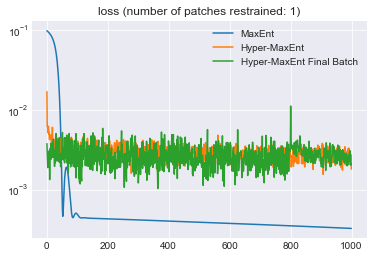

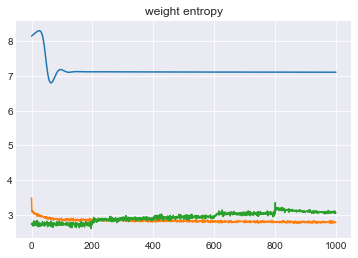

In [28]:
plt.plot(me_history.history['loss'],label='MaxEnt')
plt.plot(hme_history.history['loss'],label='Hyper-MaxEnt')
plt.plot(hme_final_history.history['loss'],label='Hyper-MaxEnt Final Batch')
plt.title('loss (number of patches restrained: {})'.format(len(restrained_patches)))
plt.yscale('log')
plt.legend()
# plt.savefig('loss_{}_restraints'.format(len(restrained_patches)),dpi= 300)
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

# plt.plot(hme_history.history['prior-loss'])
# plt.title('neg log-likelihood')
# plt.show()

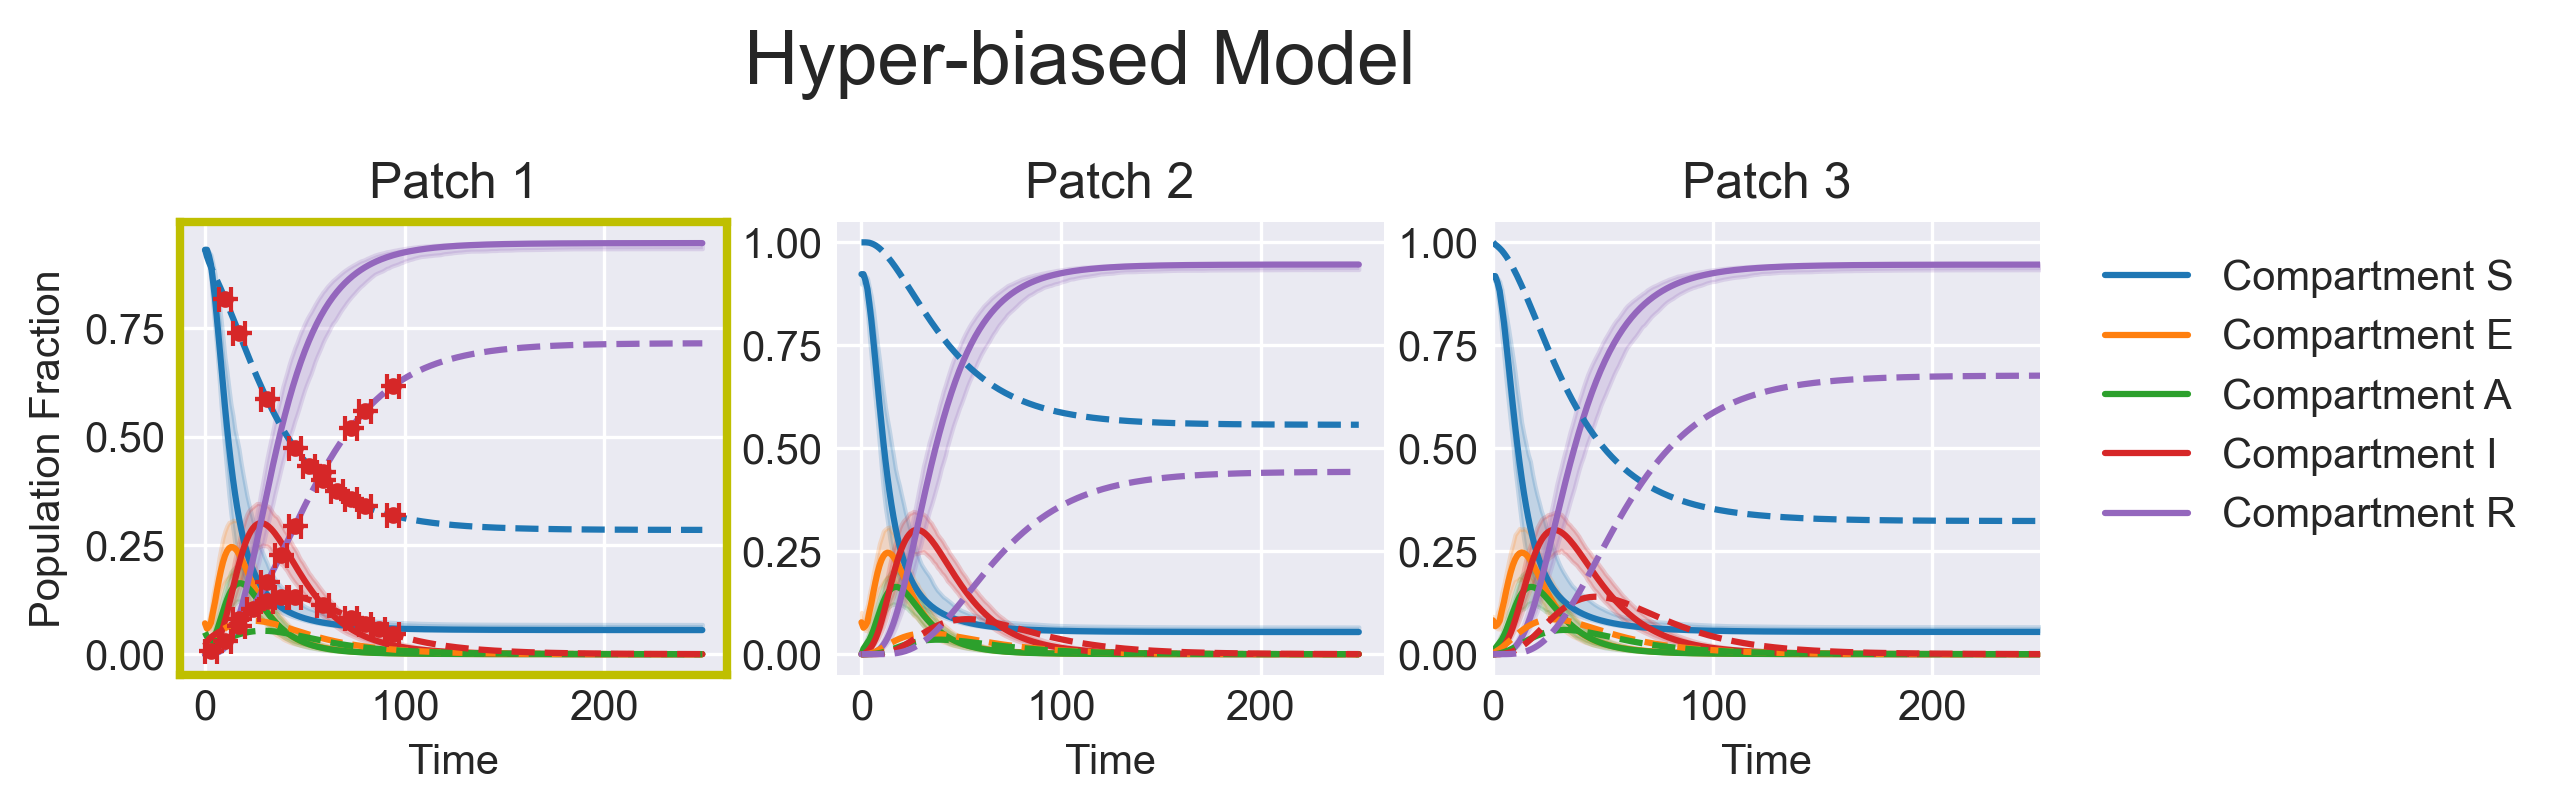

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Hyper-biased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,1,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,2,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1))
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()